##Блок библиотек

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from torch.utils.data import random_split
import random
from IPython.display import display, HTML
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import OneCycleLR
import copy
from sklearn.model_selection import train_test_split
import re
from torch import nn, optim
from torchvision.models import efficientnet_b0, resnet18

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


##Загрузка данных
Здесь необходимо загрузить файл kaggle.json из настроек аккаунта в Kaggle со своим ключом.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"semga1337","key":"71ad53ae3510851a09ee86c395e0a92b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dl-2025-competition-1
!unzip dl-2025-competition-1.zip

dl-2025-competition-1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  dl-2025-competition-1.zip
replace data/test/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


------------
## 1 ПУНКТ

1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы.

Распределение изображений по классам:


Класс,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Количество,110,109,143,119,136,45,123,137,45,49,134,72,117,109,50,137,125,140,47,87,138,131,115,32,117,70,44,128,149,118,128,78,88,46,118,72,118,58,125,104,125,149,108,34,135,133,95,61,70,108,55,139,127,56,117,76,139,127,80,146,37,80,79,90,144,69,111,52,95,44,38,48,99,94,138,63,48,44,75,88,84,48,77,138,73,150,71,106,107,96,34,147,106,150,110,101,61,40,112,72
"Доля, %",1.16%,1.15%,1.5%,1.25%,1.43%,0.47%,1.29%,1.44%,0.47%,0.52%,1.41%,0.76%,1.23%,1.15%,0.53%,1.44%,1.31%,1.47%,0.49%,0.91%,1.45%,1.38%,1.21%,0.34%,1.23%,0.74%,0.46%,1.35%,1.57%,1.24%,1.35%,0.82%,0.93%,0.48%,1.24%,0.76%,1.24%,0.61%,1.31%,1.09%,1.31%,1.57%,1.14%,0.36%,1.42%,1.4%,1.0%,0.64%,0.74%,1.14%,0.58%,1.46%,1.34%,0.59%,1.23%,0.8%,1.46%,1.34%,0.84%,1.54%,0.39%,0.84%,0.83%,0.95%,1.51%,0.73%,1.17%,0.55%,1.0%,0.46%,0.4%,0.5%,1.04%,0.99%,1.45%,0.66%,0.5%,0.46%,0.79%,0.93%,0.88%,0.5%,0.81%,1.45%,0.77%,1.58%,0.75%,1.11%,1.13%,1.01%,0.36%,1.55%,1.11%,1.58%,1.16%,1.06%,0.64%,0.42%,1.18%,0.76%


Статистика распределения изображений по классам:


Метрика,Значение
Количество классов,100
Всего изображений,9510
Среднее на класс,95.1
Стандартное отклонение,35.4
Минимум,32 (класс 23)
25-й перцентиль,67.5
Медиана,100.0
75-й перцентиль,125.5
Максимум,150 (класс 85)
Интерквартильный размах,58.0


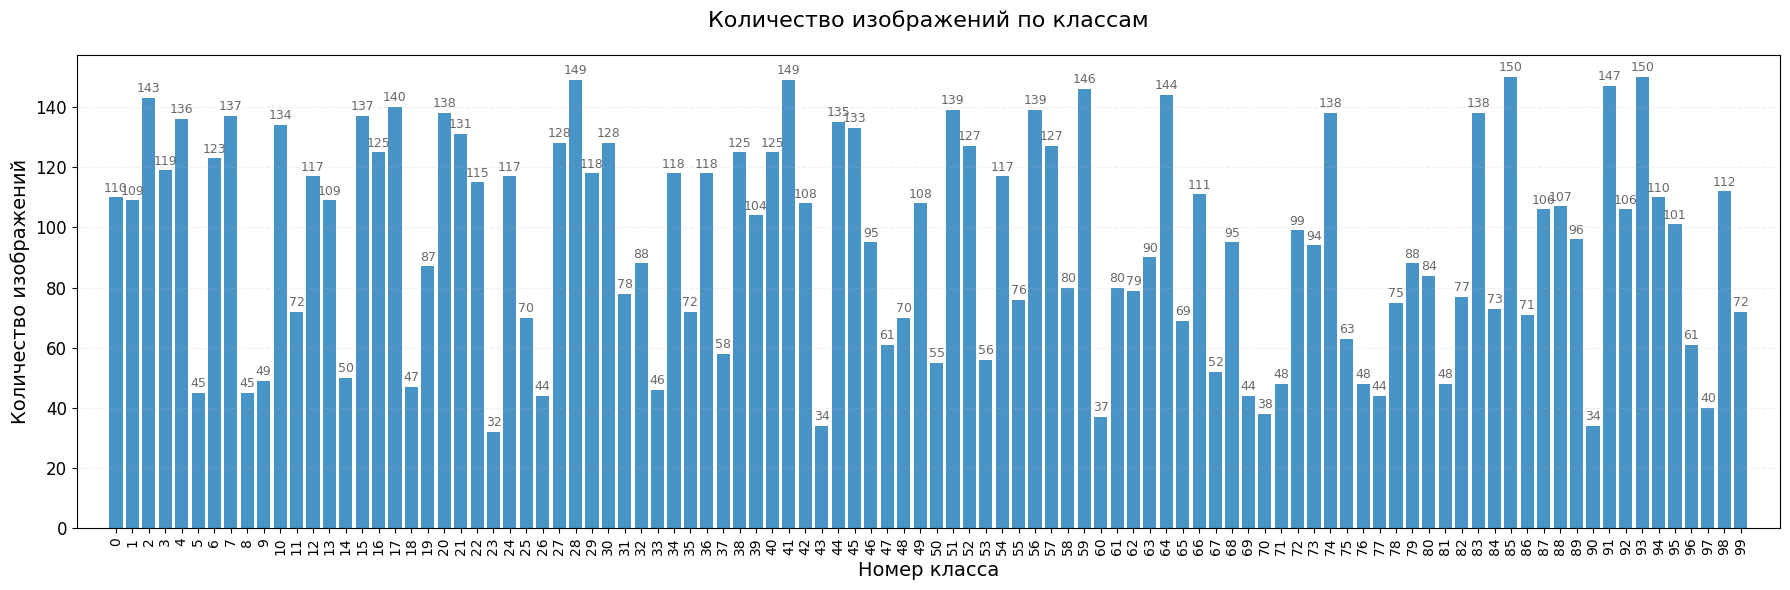

In [5]:
train_path = "data/train"
classes = sorted([int(f) for f in os.listdir(train_path) if f.isdigit()])
class_stats = []

for class_id in classes:
    class_name = str(class_id)
    class_path = os.path.join(train_path, class_name)
    num_images = len(os.listdir(class_path))
    total_images = sum(len(os.listdir(os.path.join(train_path, str(c)))) for c in classes)
    class_stats.append({
        'Класс': class_id,
        'Количество': num_images,
        'Доля, %': round(num_images / total_images * 100, 2)
    })

df_stats = pd.DataFrame(class_stats).sort_values('Класс')

df_stats_horizontal = df_stats
df_stats_horizontal = pd.DataFrame({
    'Класс': df_stats['Класс'].astype(str),
    'Количество': df_stats['Количество'],
    'Доля, %': df_stats['Доля, %'].apply(lambda x: f"{x}%")}).set_index('Класс').T

df_stats_horizontal = df_stats_horizontal.style
print("Распределение изображений по классам:")
display(df_stats_horizontal)

#статистика

stats = df_stats['Количество'].describe(percentiles=[.25, .5, .75])
additional_stats = {
    'IQR': stats['75%'] - stats['25%'],
    'Коэф. вариации': (stats['std'] / stats['mean']) * 100,
    'Отношение макс/мин': stats['max'] / stats['min']
}

stats_df = pd.DataFrame({
    'Метрика': [
        'Количество классов',
        'Всего изображений',
        'Среднее на класс',
        'Стандартное отклонение',
        'Минимум',
        '25-й перцентиль',
        'Медиана',
        '75-й перцентиль',
        'Максимум',
        'Интерквартильный размах',
        'Коэффициент вариации',
        'Отношение макс/мин'
    ],
    'Значение': [
        len(df_stats),
        f"{total_images:.0f}",
        f"{stats['mean']:.1f}",
        f"{stats['std']:.1f}",
        f"{stats['min']:.0f} (класс {df_stats.loc[df_stats['Количество'].idxmin(), 'Класс']})",
        f"{stats['25%']:.1f}",
        f"{stats['50%']:.1f}",
        f"{stats['75%']:.1f}",
        f"{stats['max']:.0f} (класс {df_stats.loc[df_stats['Количество'].idxmax(), 'Класс']})",
        f"{additional_stats['IQR']:.1f}",
        f"{additional_stats['Коэф. вариации']:.1f}%",
        f"{additional_stats['Отношение макс/мин']:.1f}x"
    ]
})

stats_df = stats_df.style.hide(axis='index')
print('Статистика распределения изображений по классам:')
display(stats_df)

#график
plt.figure(figsize=(18, 6))
ax = sns.barplot(data=df_stats, x='Класс', y='Количество', color='#3498db')
ax.set_title('Количество изображений по классам', fontsize=16, pad=20)
ax.set_xlabel('Номер класса', fontsize=14)
ax.set_ylabel('Количество изображений', fontsize=14)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',  # Выравнивание по верхнему краю столбца
        xytext=(0, 2),  # Минимальное смещение (2 точки)
        textcoords='offset points',
        fontsize=9,  # Уменьшенный размер шрифта
        fontweight='light',  # Тонкое начертание
        color='dimgray'  # Неяркий цвет
    )

plt.xticks(rotation=90, ha='center', fontsize=10, fontfamily='sans-serif')
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.margins(x=0.02, y=0.05)
plt.tight_layout()
plt.show()

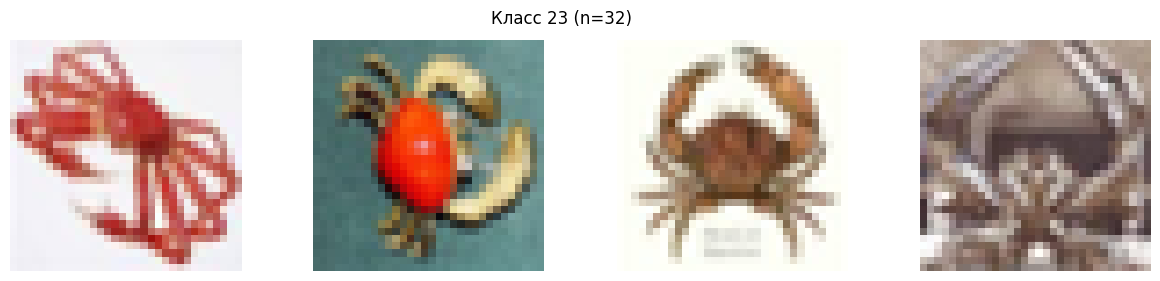

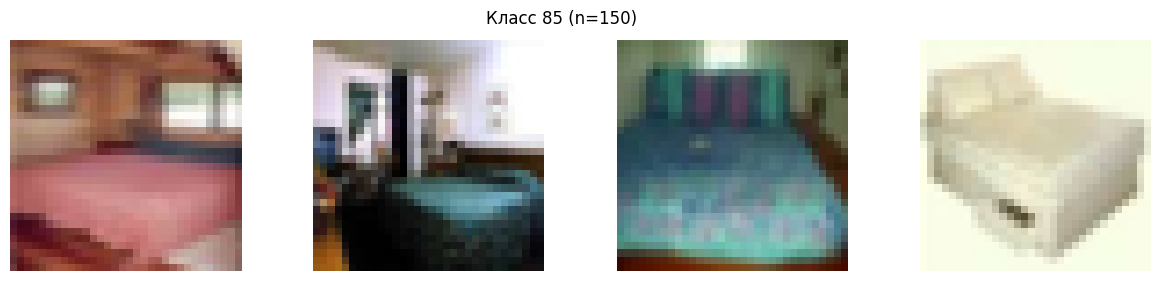

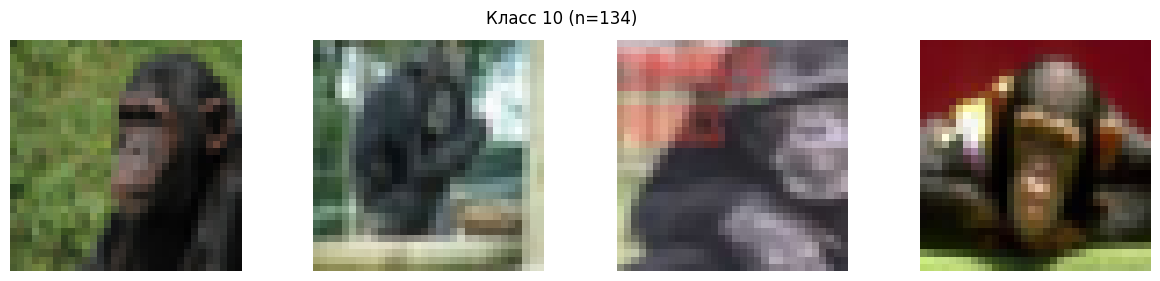

In [6]:
def show_samples(class_id, n=4):
    class_path = os.path.join(train_path, str(class_id))
    images = random.sample(os.listdir(class_path), n)
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for img_name, ax in zip(images, axs):
        img = Image.open(os.path.join(class_path, img_name))
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f'Класс {class_id} (n={len(os.listdir(class_path))})')
    plt.show()

show_samples(23)  # Самый маленький класс
show_samples(85)  # Самый большой класс
show_samples(10)

Анализ распределения изображений по классам выявил несколько ключевых особенностей. Набор данных содержит 100 классов с общим объемом 9510 изображений, что в среднем составляет около 95 изображений на класс, однако распределение существенно неравномерное. Медианное значение (100 изображений) превышает среднее, что указывает на наличие множества малых классов.

Дисбаланс ярко выражен — размер классов варьируется от 32 (класс 23) до 150 изображений (класс 85), с коэффициентом вариации 37.3% и соотношением максимум/минимум 4.7x. Квартальные значения показывают, что 25% самых малых классов содержат ≤67 изображений, а 25% самых больших — ≥125. Интерквартильный размах (58) подтверждает значительный разброс в середине распределения.

Визуальный анализ подтвердил, что дисбаланс размеров классов коррелирует с разнообразием их визуального содержания, что требует дифференцированного подхода к обработке разных категорий.

------------
## 2 ПУНКТ

2) Проанализировать хороший аугментационный пайплайн с помощью albumentations. Собрать подготовленный пайплайн в погрузчик данных на модель.

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        class_names = sorted(d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d)))
        self.class_to_idx = {name: i for i, name in enumerate(class_names)}

        self.samples = []
        for cls in class_names:
            folder = os.path.join(root_dir, cls)
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.jpg', '.png')):
                    path = os.path.join(folder, fname)
                    self.samples.append((path, self.class_to_idx[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(image=img)['image']
        else:
            img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        return img, label

train_transform = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_path = "data/train"
full_ds = CustomDataset(train_path, transform=train_transform)
train_len = int(0.8 * len(full_ds))
val_len = len(full_ds) - train_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len])

val_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4, pin_memory=True, drop_last=True)

imgs, lbls = next(iter(train_loader))
print("Batch shapes:", imgs.shape, lbls.shape)  #[64,3,64,64],[64]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch shapes: torch.Size([64, 3, 64, 64]) torch.Size([64])


### Вывод одного батча

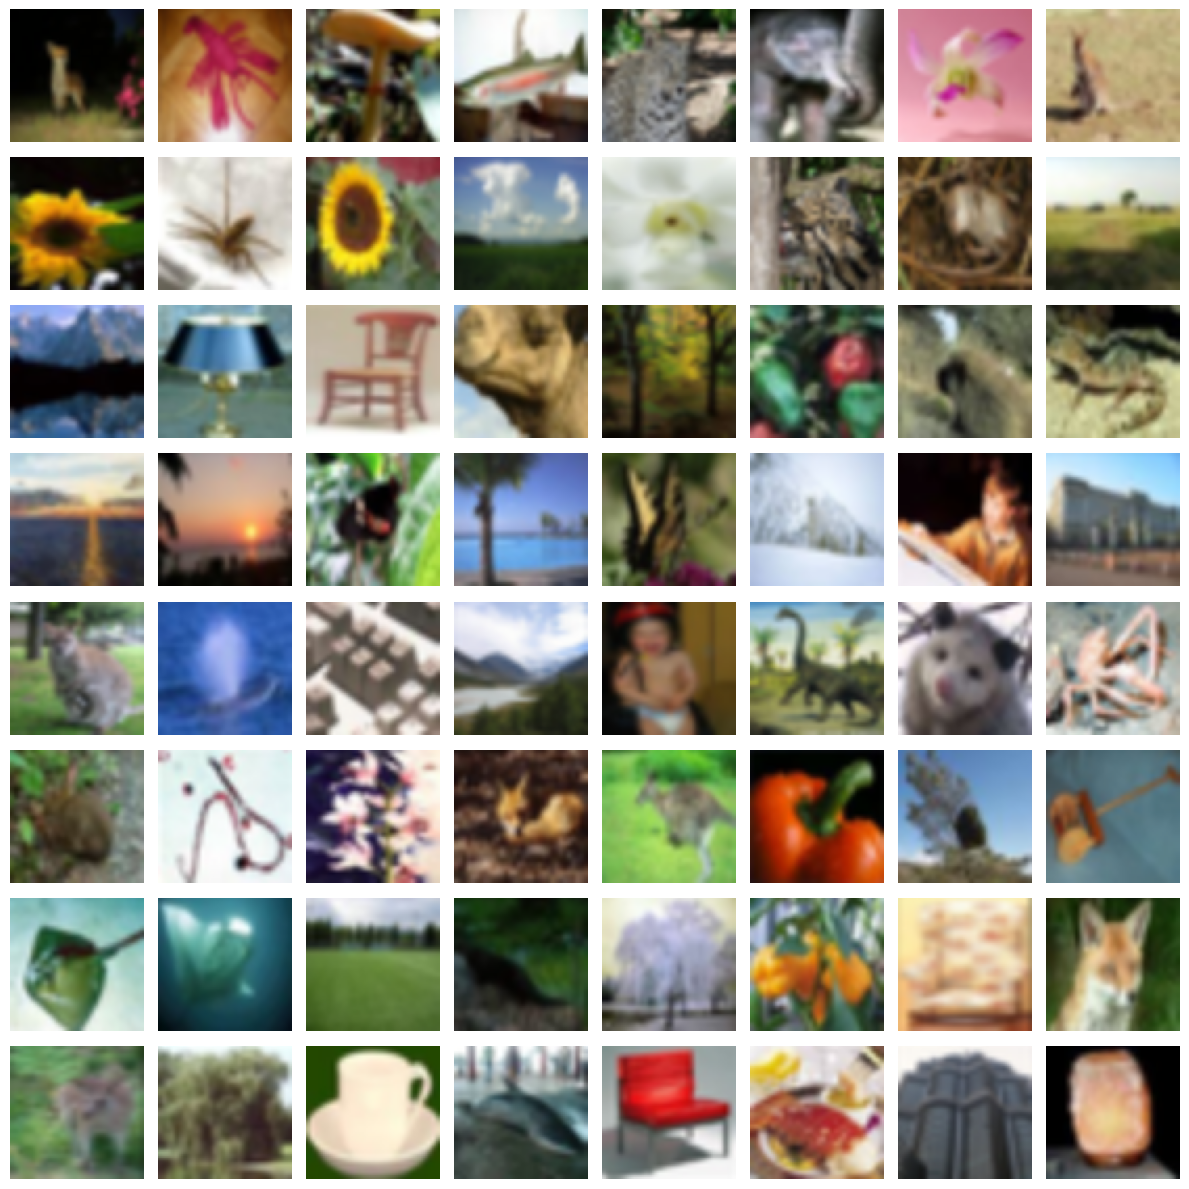

In [8]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_tensor = img_tensor * std + mean
    return img_tensor

def show_batch(loader):
    images, labels = next(iter(loader))
    images = denormalize(images)
    grid_size = 8
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    for i in range(grid_size * grid_size):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax = axes[i // grid_size, i % grid_size]
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_batch(train_loader)

-----------
## 3 ПУНКТ

3) Поделить данные на трейн-валидацию, обучить базовую модель (с и без transfer learning) без навороченных аугментаций (только отражение во горизонтали и вертикали) и с навороченными. Попробуйте применить продвинутые методы апскейлинга для подачи модели нужного размера для transfer learning. Проверить результаты моделей с аугментацией на тесте и без. Сделать аугментацию моделей на валидации (или тесте на каггле). Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Блок функций и классов

In [10]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.class_names = sorted(
            [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))],
            key=natural_sort_key
        )
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        self.image_paths = []
        self.labels = []
        for class_name in self.class_names:
            class_folder = os.path.join(root_dir, class_name)
            img_names = sorted(os.listdir(class_folder), key=natural_sort_key)
            for img_name in img_names:
                self.image_paths.append(os.path.join(class_folder, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        if img is None:
            raise ValueError(f"Failed to load image: {self.image_paths[idx]}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0

        if self.transform:
            img = self.transform(image=img)['image']

        return img, self.labels[idx]

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.gpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.gpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        confidence = 1.0 - self.smoothing
        logprobs = torch.nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        return (confidence * nll_loss + self.smoothing * smooth_loss).mean()

def get_model(model_type, num_classes):
    if model_type == 'simple':
        return SimpleCNN(num_classes)
    elif model_type == 'efficientnet':
        model = efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        return model
    elif model_type == 'resnet':
        model = resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        return model
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def get_transforms(aug_type='simple', img_size=224):
    if aug_type == 'simple':
        train_tf = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(img_size, img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    elif aug_type == 'advanced':
        train_tf = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.RandomResizedCrop(
                size=(img_size, img_size),
                scale=(0.8, 1.0),
                ratio=(0.75, 1.33),
                p=0.5
            ),
            A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
            A.Resize(img_size, img_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
    else:
        raise ValueError(f"Unknown augmentation type: {aug_type}")

    val_tf = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    return train_tf, val_tf

class TransformSubset(Dataset):
        def __init__(self, dataset, indices, transform):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform

        def __len__(self):
            return len(self.indices)

        def __getitem__(self, idx):
            img, label = self.dataset[self.indices[idx]]
            if self.transform:
                img = self.transform(image=img)['image']
            return img, label

def train_model(
    model, train_loader, val_loader, optimizer, scheduler,
    device, num_epochs=20, patience=5, save_path="best_model.pth",
    warmup_epochs=3
):
    criterion = LabelSmoothingCrossEntropy()

    best_model = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    early_stopping_counter = 0

    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        model.train()
        running_loss, correct, total = 0, 0, 0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Warmup learning rate
            if epoch < warmup_epochs and scheduler:
                scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss, val_acc = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered")
                break

        # Step scheduler after warmup
        if epoch >= warmup_epochs and scheduler:
            scheduler.step()

    model.load_state_dict(best_model)
    return model, history

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

def plot_history(history, title='Training History'):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

def predict_test_images(model, test_loader, device, class_to_idx, output_file):
    model.eval()
    predictions = []

    idx_to_class = {v: k for k, v in class_to_idx.items()}

    with torch.no_grad():
        for imgs, paths in tqdm(test_loader, desc="Predicting"):
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)

            for path, pred in zip(paths, preds.cpu().numpy()):
                image_id = int(os.path.splitext(os.path.basename(path))[0])
                predictions.append((image_id, idx_to_class[pred]))

    submission_df = pd.DataFrame(predictions, columns=['id', 'target'])
    submission_df = submission_df.sort_values('id')
    submission_df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

class TestDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.transform = transform
        self.paths = []
        for root, _, files in os.walk(image_dir):
            for fname in files:
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    full_path = os.path.join(root, fname)
                    self.paths.append(full_path)
        self.paths.sort(key=lambda p: natural_sort_key(os.path.basename(p)))

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Cannot read image {path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        if self.transform:
            img = self.transform(image=img)['image']
        return img, path

### Обучение модели и выбор параметров (+ здесь же модель с Каггла)
В данном блоке модель определяется выбором параметров в переменной config

Лучший скор на каггле выбил при следующей конфигурации параметров:

config = {
        'data_dir': 'data',
        'model_type': 'efficientnet',
        'aug_type': 'advanced',
        'batch_size': 32,
        'num_epochs': 10,
        'patience': 7,
        'warmup_epochs': 3,
        'learning_rate': 3e-4,
        'img_size': 224
    }

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-7597ff56d9a3>:102: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.5),
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weig

Epoch 1/10


Train Loss: 4.0653 Acc: 0.1410 | Val Loss: 4.0144 Acc: 0.1325
Epoch 2/10


Train Loss: 2.9218 Acc: 0.3766 | Val Loss: 4.8759 Acc: 0.0494
Epoch 3/10


Train Loss: 2.3762 Acc: 0.5104 | Val Loss: 4.9789 Acc: 0.0678
Epoch 4/10


Train Loss: 2.1575 Acc: 0.5626 | Val Loss: 4.5000 Acc: 0.1488
Epoch 5/10


Train Loss: 1.9000 Acc: 0.6534 | Val Loss: 2.3135 Acc: 0.5158
Epoch 6/10


Train Loss: 1.6567 Acc: 0.7199 | Val Loss: 2.7916 Acc: 0.4117
Epoch 7/10


Train Loss: 1.5038 Acc: 0.7777 | Val Loss: 2.0425 Acc: 0.6120
Epoch 8/10


Train Loss: 1.3664 Acc: 0.8329 | Val Loss: 2.0092 Acc: 0.6136
Epoch 9/10


Train Loss: 1.2839 Acc: 0.8616 | Val Loss: 1.6372 Acc: 0.7334
Epoch 10/10


Train Loss: 1.2415 Acc: 0.8792 | Val Loss: 1.6103 Acc: 0.7424


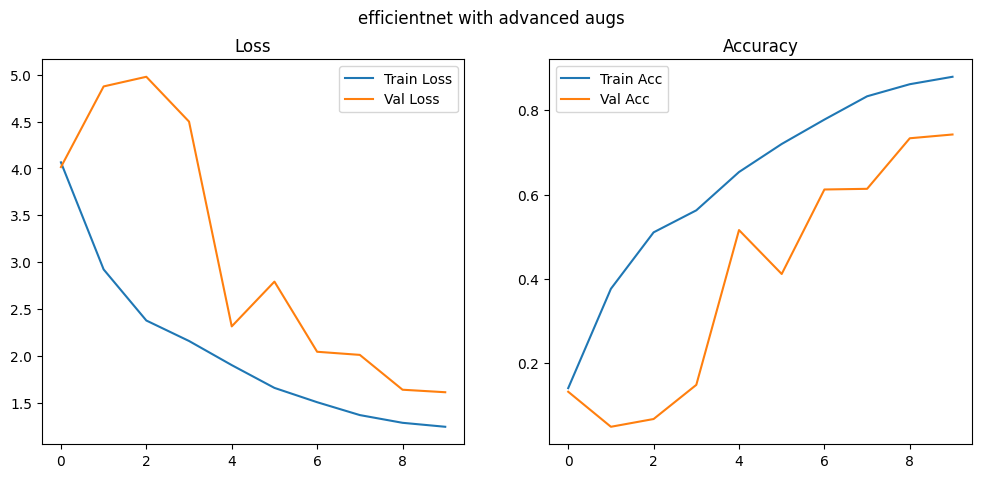

In [13]:
if __name__ == "__main__":

    # Здесь задаем параметры для выбора моделей
    config = {
        'data_dir': 'data',
        'model_type': 'efficientnet',  # 'simple' или 'efficientnet' или 'resnet' (выбор типа модели)
        'aug_type': 'advanced',  # 'simple' или 'advanced' (выбор аугментации)
        'batch_size': 32,
        'num_epochs': 10,
        'patience': 7,
        'warmup_epochs': 3,
        'learning_rate': 3e-4,
        'img_size': 224  # Для transfer learning моделей
    }

    # Создаем папку для моделей
    os.makedirs('models', exist_ok=True)
    model_save_path = f"models/best_{config['model_type']}_{config['aug_type']}.pth"
    output_csv = f"submission_{config['model_type']}_{config['aug_type']}.csv"

    train_tf, val_tf = get_transforms(config['aug_type'], config['img_size'])

    full_dataset = CustomDataset(os.path.join(config['data_dir'], 'train'))

    train_idx, val_idx = train_test_split(
        range(len(full_dataset)),
        test_size=0.2,
        stratify=full_dataset.labels
    )

    train_dataset = TransformSubset(full_dataset, train_idx, train_tf)
    val_dataset = TransformSubset(full_dataset, val_idx, val_tf)
    test_dataset = TestDataset(
        os.path.join(config['data_dir'], 'test'),
        transform=val_tf
    )

    # Создаем загрузчики
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    model = get_model(config['model_type'], len(full_dataset.class_names))
    model = model.to(device)

    # Оптимизатор и шедулер
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['num_epochs'] - config['warmup_epochs']
    )

    # Обучаем модель
    model_trained, history = train_model(
        model, train_loader, val_loader, optimizer, scheduler, device,
        num_epochs=config['num_epochs'],
        patience=config['patience'],
        save_path=model_save_path,
        warmup_epochs=config['warmup_epochs']
    )

    # Отрисовываем график
    plot_history(history, title=f"{config['model_type']} with {config['aug_type']} augs")

### Предсказание классов на тесте

In [14]:
test_dataset = TestDataset(
    os.path.join(config['data_dir'], 'test'),
    transform=val_tf
)

test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

predict_test_images(
        model_trained,
        test_loader,
        device,
        full_dataset.class_to_idx,
        output_file=f"submission_{config['model_type']}_{config['aug_type']}.csv"
    )

print(f"Total test images: {len(test_dataset)}")

Predicting: 100%|██████████| 122/122 [00:09<00:00, 12.51it/s]

Predictions saved to submission_efficientnet_advanced.csv
Total test images: 3878
